# 8. Ajuste avanzado modelo Extra Trees clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE), incluyendo variable ciclo
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No     |
| :-------                  | :------:    |
| Escalado de datos         | No          |
| Ajuste de hiperparametros | Si          |
| Sobremuestreo             | Si          |
| Ajuste de pesos de clase  | No          |
| Incluye variable ciclo    | Si          |


### Cargar librerias

In [22]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import pandas_profiling
np.random.seed(9999) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report

# sobremuestreo
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot


### Funciones

In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
    print('\n')
    print("MATRIZ DE CONFUSION")
    print('\n')
    matriz = confusion_matrix(label_test, label_pred)
    #print(matriz)
    classes = ["Funcional","Falla potencial"]
    cm = ConfusionMatrix(modelo, classes=classes, label_encoder={0:"Funcional", 1:"Falla Potencial"})
    cm.fit(data_train, label_train)
    cm.score(data_test, label_test)
    cm.show()
    # Medidas de desempeño del modelo
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(modelo.score(data_test, label_test)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
    
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
   
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [3]:
# ruta para grabar medidas de desempeño
ruta4a = "D:/alexh/Documents/Maestria en estadistica/proyecto de grado/cuadernos proyecto/Nasa Turbo Fan/Modelos 4a.xlsx"
writer = pd.ExcelWriter(ruta4a, engine='openpyxl')

### Preparar datos agil

In [4]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train['clase2']=train['clase1']
train.loc[train['ttf']<=15, 'clase2'] =2
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test['clase2']=test['clase1']
test.loc[test['ttf']<=15, 'clase2'] =2

# incluyendo la variable ciclo ID
data_train=train.iloc[:,np.r_[1:26]]
label_train=train.iloc[:,27]
data_test=test.iloc[:,np.r_[1:26]]
label_test=test.iloc[:,27]
label_train2=train.iloc[:,28]
label_test2=test.iloc[:,28]



Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

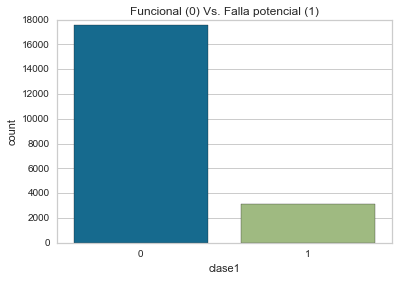

In [5]:
# conteo de observaciones por clase de la base entrenamiento
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [6]:
# sobremuestreo de minorías sintéticas (SMOTE)

data_traino, label_traino = SMOTE().fit_resample(data_train, label_train)
print(sorted(Counter(label_traino).items()))

[(0, 17531), (1, 17531)]


In [7]:
label_train=pd.Series(label_traino)

Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

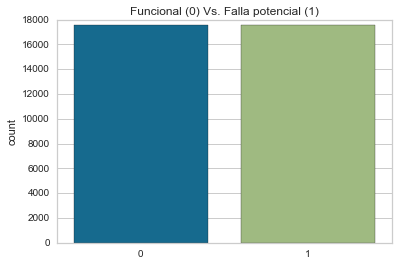

In [8]:
# grafica de base de entrenamiento equilibrada
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [9]:
data_train= pd.DataFrame(data_traino, columns=data_train.columns)

In [10]:
print("numero de dimensiones =", data_train.ndim)
print("tamaño de la tabla =", data_train.shape)
print("total datos =", data_train.size)

numero de dimensiones = 2
tamaño de la tabla = (35062, 25)
total datos = 876550


In [11]:
print("numero de dimensiones =", label_train.ndim)
print("tamaño de la tabla =", label_train.shape)
print("total datos =", label_train.size)

numero de dimensiones = 1
tamaño de la tabla = (35062,)
total datos = 35062


In [12]:
data_train.head()

,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190
1,2.0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236
2,3.0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442
3,4.0,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739
4,5.0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044


## Modelos de clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE), incluyendo variable ciclo

## Extra Trees Classifier hiperparametros por defecto

In [15]:
modelo9=ExtraTreesClassifier(n_estimators=100, random_state=0)
modelo9.fit(data_train, label_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)



MATRIZ DE CONFUSION




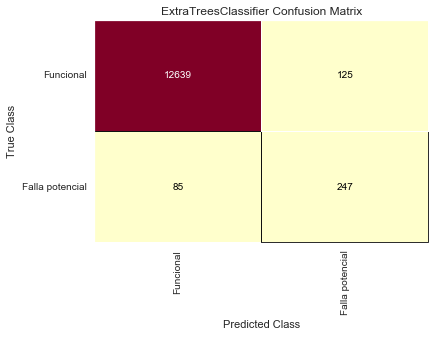



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9839645693341478
ROC AUC: 0.867091367664327
------------------------------------------------------------
Precisión por clase: [0.99331971 0.66397849]
Sensibilidad - Recall por clase: [0.99020683 0.7439759 ]
F1 por clase: [0.99176083 0.70170455]
------------------------------------------------------------
F1 Macro: 0.8467326870398904
F1 Micro: 0.9839645693341478
F1 Weighted: 0.9844075386120504
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.867091367664327
Sensibilidad - Recall Micro: 0.9839645693341478
Sensibilidad - Recall Weighted: 0.9839645693341478
------------------------------------------------------------
Precisión Macro: 0.8286491027032143
Precisión Micro: 0.9839645693341478
Precisión Weighted: 0.984970498522172
------------------------------------------------------------
Verdaderos positivos - True Positives: 247
Verdaderos negativos - True Negatives: 12639
Falsos positivos 

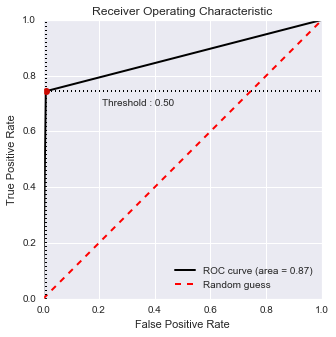

In [16]:
label_pred9 = modelo9.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo9, label_pred9)

## Stratified k-fold cross-validation

Evaluaremos el modelo utilizando validación cruzada estratificada repetida de k veces, con 10 repeticiones y 20 pliegues. Informaremos la desviación media y estándar de la precisión del modelo en todas las repeticiones y pliegues

In [21]:
# evaluar extra trees algorithm para la clasifiacion binaria

model = ExtraTreesClassifier()

cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=10, random_state=1)
n_scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.976 (0.004)


El resultado es una exactitud media de 0.976 con una desviacion estandar de 0.004

## Ajuste de hiperparametros
tomado de:
https://machinelearningmastery.com/extra-trees-ensemble-with-python/

### Explorar el numero de arboles

In [31]:
# funcion para evaluar lista de modelos
def get_models():
    models = dict()
    models['10'] = ExtraTreesClassifier(n_estimators=10)
    models['50'] = ExtraTreesClassifier(n_estimators=50)
    models['100'] = ExtraTreesClassifier(n_estimators=100)
    models['500'] = ExtraTreesClassifier(n_estimators=500)
    models['1000'] = ExtraTreesClassifier(n_estimators=1000)
    return models

# funcion para evaluar modelo usando CV
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>10 0.976 (0.003)
>50 0.977 (0.003)
>100 0.978 (0.003)
>500 0.978 (0.003)
>1000 0.978 (0.003)


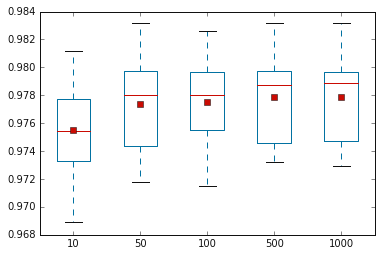

In [32]:
# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

se observa que la exactitud aumenta y se mantiene estable después de unos 100 árboles


### Ajustar el Number of Features (max_features)

>1 0.975 (0.003)
>2 0.976 (0.003)
>3 0.977 (0.003)
>4 0.977 (0.003)
>5 0.978 (0.003)
>6 0.978 (0.003)
>7 0.978 (0.003)
>8 0.978 (0.003)
>9 0.978 (0.003)
>10 0.978 (0.003)
>11 0.979 (0.003)
>12 0.979 (0.003)
>13 0.979 (0.003)
>14 0.979 (0.003)
>15 0.979 (0.003)
>16 0.979 (0.003)
>17 0.979 (0.003)
>18 0.979 (0.003)
>19 0.979 (0.003)
>20 0.979 (0.003)


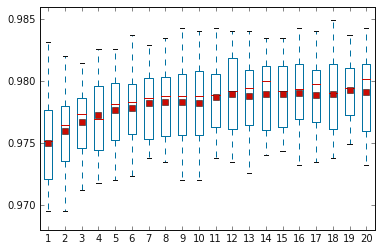

In [33]:
# lista de modelos a evaluar max_features entre 2 y 20
def get_models():
    models = dict()
    for i in range(1, 21):
        models[str(i)] = ExtraTreesClassifier(n_estimators=100, max_features=i)
    return models

# funcion para evaluar modelo usando CV
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

los resultados sugieren que un valor entre 13 y 14 sería apropiado

### Ajuste de Minimum Samples per Split

>2 0.979 (0.003)
>3 0.979 (0.003)
>4 0.978 (0.003)
>5 0.978 (0.003)
>6 0.978 (0.003)
>7 0.977 (0.003)
>8 0.976 (0.003)
>9 0.976 (0.003)
>10 0.975 (0.004)
>11 0.975 (0.003)
>12 0.975 (0.003)
>13 0.974 (0.003)
>14 0.974 (0.003)


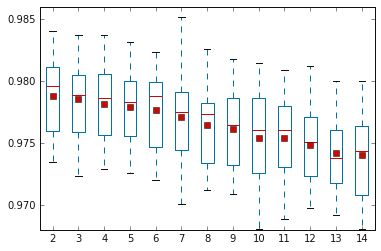

In [34]:
# evaluar entre 2 (default) y 14 muestras
def get_models():
    models = dict()
    for i in range(2, 15):
        models[str(i)] = ExtraTreesClassifier(min_samples_split=i, n_estimators=100, max_features=14)
    return models

# funcion para evaluar modelo usando CV
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


se observa que los valores pequeños resultan en una mejor exactitud, mantenemos el valor predeterminado de 2

## Entrenar modelo con hiperparametros ajustados 

In [41]:
modelo=ExtraTreesClassifier(min_samples_split=2, n_estimators=100, max_features=14, random_state=0)
modelo.fit(data_train, label_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features=14, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)



MATRIZ DE CONFUSION




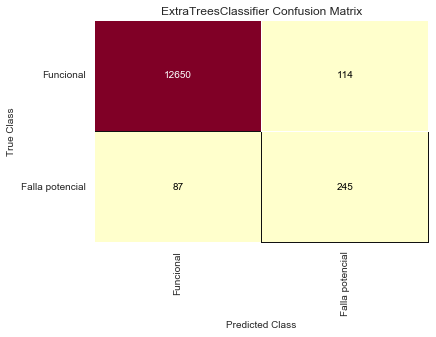



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9846518020769701
ROC AUC: 0.8645102188761312
------------------------------------------------------------
Precisión por clase: [0.99316951 0.68245125]
Sensibilidad - Recall por clase: [0.99106863 0.73795181]
F1 por clase: [0.99211796 0.70911722]
------------------------------------------------------------
F1 Macro: 0.8506175887884082
F1 Micro: 0.9846518020769701
F1 Weighted: 0.9849435331337045
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8645102188761313
Sensibilidad - Recall Micro: 0.9846518020769701
Sensibilidad - Recall Weighted: 0.9846518020769701
------------------------------------------------------------
Precisión Macro: 0.8378103798225205
Precisión Micro: 0.9846518020769701
Precisión Weighted: 0.9852924093480753
------------------------------------------------------------
Verdaderos positivos - True Positives: 245
Verdaderos negativos - True Negatives: 12650
Falsos positiv

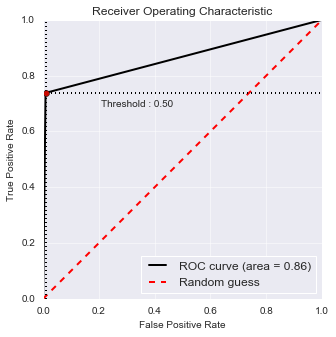

In [42]:
label_pred = modelo.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred)